In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [2]:
game_df = pd.read_csv('game.csv')
game_info_df = pd.read_csv('game_info.csv')
team_df = pd.read_csv('team.csv')
team_details_df = pd.read_csv('team_details.csv')

In [3]:
game_merge_df = pd.merge(game_info_df, game_df, on='game_id', how='left')
game_merge_df.drop('game_date_y', axis=1, inplace=True)
game_merge_df.rename(columns={'game_date_x': 'game_date'}, inplace=True)

In [4]:
game_merge_df = game_merge_df[game_merge_df['season_id'] >= 22001]

In [5]:
team_merged_data = pd.merge(team_df, team_details_df, left_on='id', right_on='team_id', suffixes=('_team', '_details'))

In [6]:
game_team_home = pd.merge(game_merge_df, team_merged_data, left_on='team_id_home', right_on='team_id', suffixes=('', '_home'))

In [7]:
final_merged_data = pd.merge(game_team_home, team_merged_data, left_on='team_id_away', right_on='team_id', suffixes=('_home', '_away'))
final_merged_data['home_advantage'] = (final_merged_data['wl_home'] == 'W').astype(int)
final_merged_data['attendance'] = final_merged_data['attendance'].fillna(0)
final_merged_data['attendance_rate'] = final_merged_data['attendance'] / 200000

C:\Users\wzq17\AppData\Local\Temp/ipykernel_6420/3655430355.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'team_id_home'} in the result is deprecated and will raise a MergeError in a future version.
  final_merged_data = pd.merge(game_team_home, team_merged_data, left_on='team_id_away', right_on='team_id', suffixes=('_home', '_away'))


In [8]:
home_wins = final_merged_data[final_merged_data['wl_home'] == 'W'].shape[0]
home_losses = final_merged_data[final_merged_data['wl_home'] == 'L'].shape[0]

away_wins = final_merged_data[final_merged_data['wl_away'] == 'W'].shape[0]
away_losses = final_merged_data[final_merged_data['wl_away'] == 'L'].shape[0]

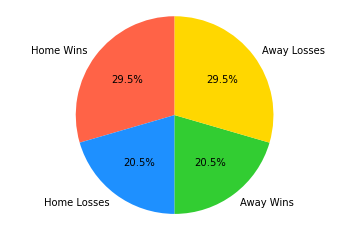

In [9]:
# Pie chart data
labels = ['Home Wins', 'Home Losses', 'Away Wins', 'Away Losses']
sizes = [home_wins, home_losses, away_wins, away_losses]
colors = ['#FF6347', '#1E90FF', '#32CD32', '#FFD700']

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the pie chart
plt.show()

In [10]:
season_group = final_merged_data.groupby('season_id')
win_rate_per_season = season_group['wl_home'].apply(lambda x: (x == 'W').sum() / x.count())

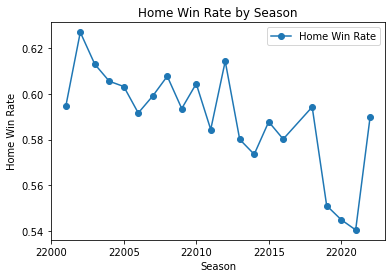

In [11]:
fig, ax = plt.subplots()

# Plot a line chart
ax.plot(win_rate_per_season.index, win_rate_per_season, marker='o', linestyle='-', label='Home Win Rate')

# Plot an area chart (uncomment the following line to use an area chart)
# ax.fill_between(win_rate_per_season.index, win_rate_per_season, color='skyblue', alpha=0.5, label='Home Win Rate')

# Customize the chart
ax.set_xlabel('Season')
ax.set_ylabel('Home Win Rate')
ax.set_title('Home Win Rate by Season')
ax.legend()

# Display the chart
plt.show()

In [12]:
# calculate win # of each team
home_wins = game_merge_df[game_merge_df['wl_home'] == 'W'].groupby('team_id_home')['wl_home'].count().reset_index()
home_wins.columns = ['team_id', 'home_wins']

# calculate home match for each number
home_games = game_merge_df.groupby('team_id_home')['wl_home'].count().reset_index()
home_games.columns = ['team_id', 'home_games']

# home advantege calculated
home_advantage = pd.merge(home_wins, home_games, on='team_id')
home_advantage['home_win_rate'] = home_advantage['home_wins'] / home_advantage['home_games']

# merge 
team_home_advantage = pd.merge(team_df, home_advantage, left_on='id', right_on='team_id')

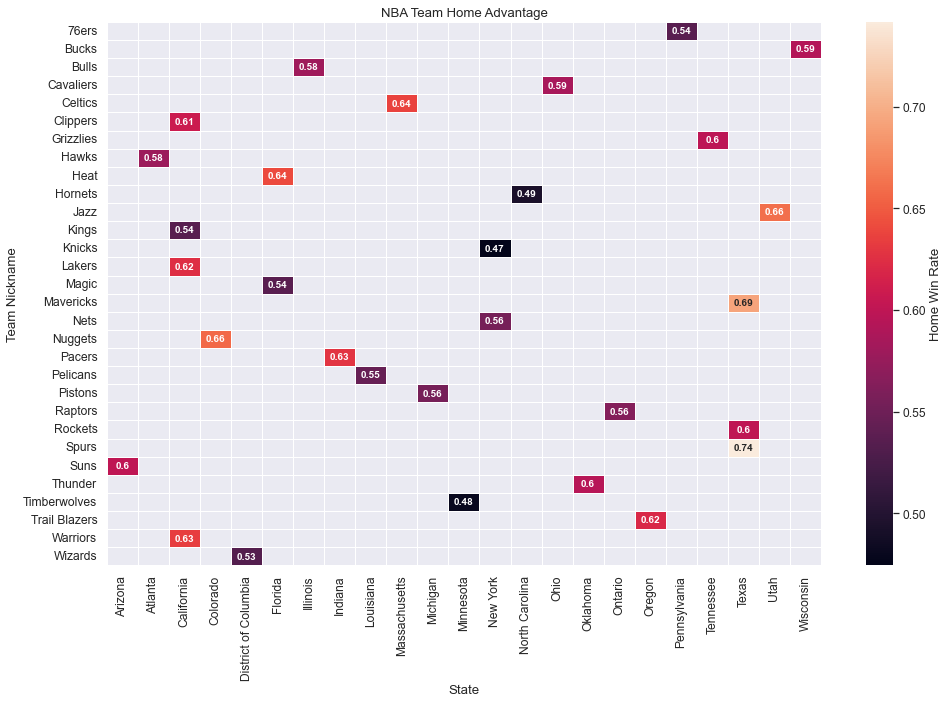

In [13]:
# Prepare the data for the heatmap
team_home_advantage_pivot = team_home_advantage.pivot(
    index="nickname",
    columns="state",
    values="home_win_rate"
)

# Create the heatmap
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.1)  # Adjust font size
heatmap = sns.heatmap(
    team_home_advantage_pivot,
    annot=True,
    linewidths=0.5,
    cbar_kws={"label": "Home Win Rate"},
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)

# Add gridlines
heatmap.set_xticks([x + 0.5 for x in range(len(team_home_advantage_pivot.columns))], minor=True)
heatmap.set_yticks([y + 0.5 for y in range(len(team_home_advantage_pivot.index))], minor=True)
heatmap.xaxis.set_ticks_position('none') 
heatmap.yaxis.set_ticks_position('none') 
heatmap.grid(which='minor', color='black', linewidth=1)

plt.title("NBA Team Home Advantage")
plt.xlabel("State")
plt.ylabel("Team Nickname")
plt.show()

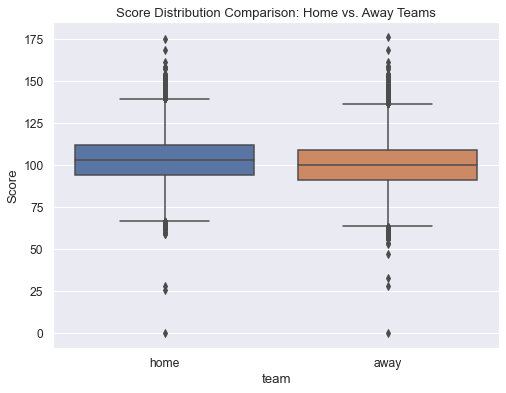

In [14]:
score_data = pd.DataFrame({
    "team": ["home"] * len(game_merge_df) + ["away"] * len(game_merge_df),
    "score": game_merge_df["pts_home"].tolist() + game_merge_df["pts_away"].tolist()
})

plt.figure(figsize=(8, 6))
sns.boxplot(x="team", y="score", data=score_data)
plt.title("Score Distribution Comparison: Home vs. Away Teams")
plt.ylabel("Score")
plt.show()

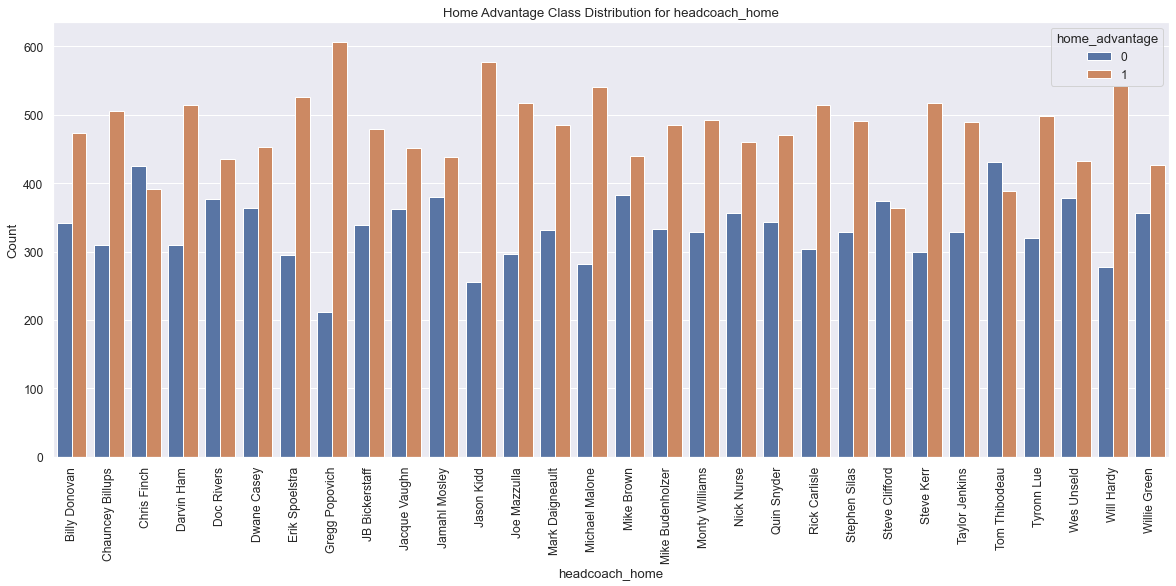

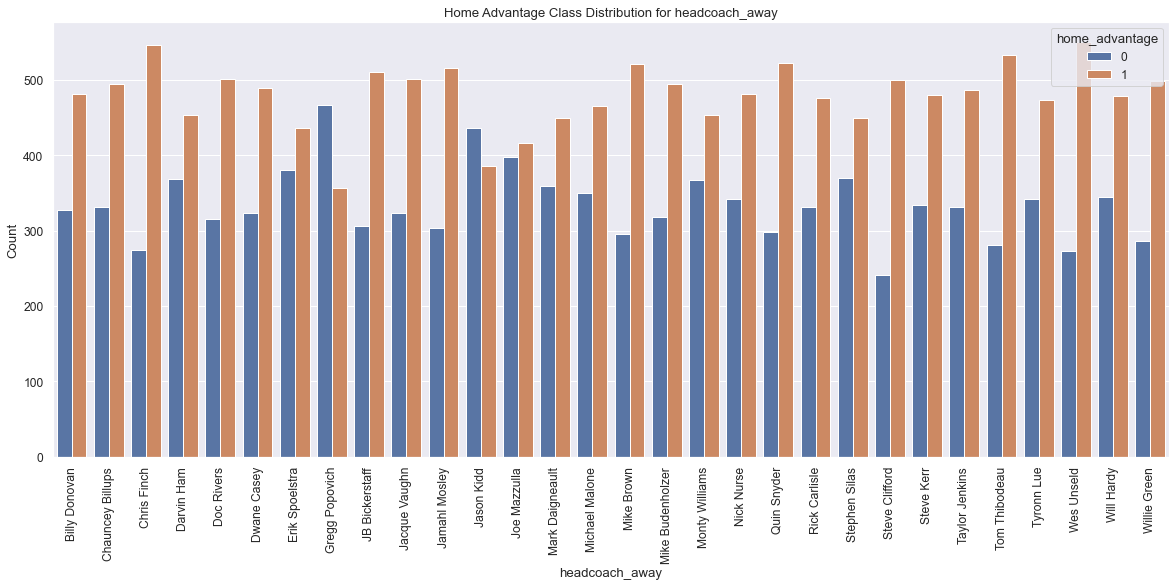

In [15]:
# Identify 'headcoach_home', 'headcoach_away'
categorical_columns = ['headcoach_home', 'headcoach_away']

# Loop through each categorical feature and create side-by-side bar plots
for col in categorical_columns:
    grouped_data = final_merged_data.groupby([col, 'home_advantage']).size().reset_index(name='count')
    
    plt.figure(figsize=(20, 8))
    sns.barplot(x=col, y='count', hue='home_advantage', data=grouped_data)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Home Advantage Class Distribution for {col}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

In [16]:
# Create a copy of the dataframe to avoid modifying the original dataframe
encoded_data = final_merged_data.copy()

# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the selected columns
encoded_columns = encoder.fit_transform(encoded_data[['headcoach_home', 'headcoach_away']])

# Assign the encoded columns back to the dataframe
encoded_data[['headcoach_home', 'headcoach_away']] = encoded_columns

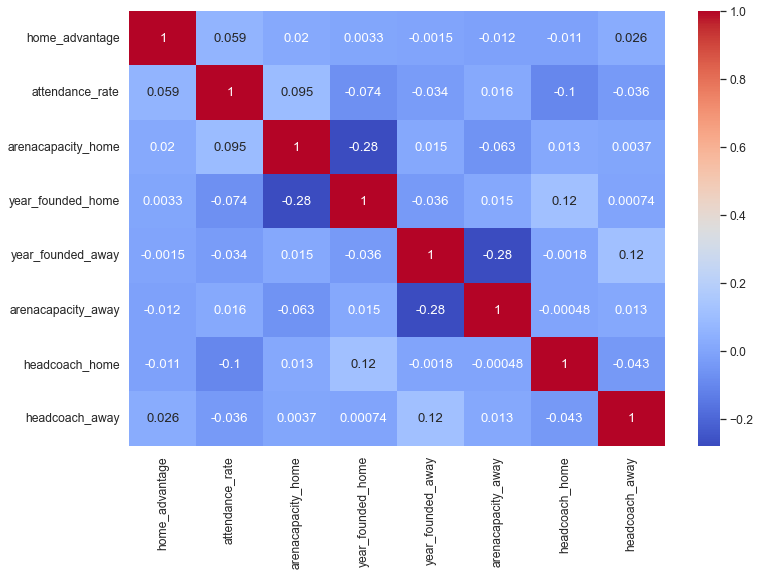

In [17]:
factors = encoded_data[['home_advantage', 'attendance_rate', 'arenacapacity_home', 'year_founded_home', 'year_founded_away', 'arenacapacity_away', 'headcoach_home', 'headcoach_away']]
correlations = factors.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()